In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd

# ---------- 各種関数の定義 ---------- #
# 可到達行列を導出する関数
def reachability_matrix(matrix):

    ###----------可達行列作成処理----------###
    # 行列のサイズを取得
    n = len(matrix)

    print('\n----------隣接行列----------')
    matrix = matrix.astype(bool)
    I = np.eye(n).astype(bool)
    adj_matrix = np.logical_or(matrix, I)
    print(adj_matrix.astype(int))

    print('\n----------可達行列----------')
    reachability_matrix = adj_matrix.copy()
    while not np.array_equal(reachability_matrix, reachability_matrix @ adj_matrix):
        reachability_matrix = reachability_matrix @ adj_matrix  #@演算子を利用することで行列積を求める（bool演算）
    print(reachability_matrix.astype(int))

    return reachability_matrix

# ノードの配置を取得する関数
def get_layer_positions(removed_rows_dict, custom_pos={}):
    positions = {}
    current_x = 0
    for layer, nodes in removed_rows_dict.items():
        for node in nodes:
            positions[node] = (current_x, -layer)
            current_x += 1
        current_x = 0

    # custom_posで指定したノード番号のx座標を辞書リストに追加する
    for node, x_coord in custom_pos.items():
        positions[node] = (x_coord, positions[node][1])

    return positions

# グラフオブジェクトを作成する関数
def create_graph(removed_rows_dict):
    G = nx.DiGraph()

    # ノードをグラフに追加
    for i in range(matrix.shape[0]):
        G.add_node(i)

    # matrixを参照しエッジを追加する関数
    def add_edges(source_node, target_nodes, target_layer_dict):
        sorted_target_nodes = sorted(target_nodes, key=lambda node: target_layer_dict[node], reverse=True)
        for target_node in sorted_target_nodes:
            if source_node != target_node and not nx.has_path(G, source_node, target_node) and not nx.has_path(G, target_node, source_node):
                G.add_edge(source_node, target_node)
                print('Edge added:', source_node, '->' , target_node)

    sorted_removed_rows_dict = dict(sorted(removed_rows_dict.items()))  # 階層を昇順にソート

    # target_nodeが属する階層の情報を辞書リストとして取得
    target_layer_dict = {}
    for layer, nodes in removed_rows_dict.items():
        for node in nodes:
            target_layer_dict[node] = layer
    
    print('\n--------エッジ追加処理--------')
    for layer, nodes in sorted_removed_rows_dict.items():
        target_nodes = []
        for node in nodes:
            target_nodes = matrix[node].nonzero()[0]
            add_edges(node, target_nodes, target_layer_dict)
    
    return G

# R, A列を取得する関数
def get_RorA(reachability_matrix):
    R_or_A = []
    for i in range(len(reachability_matrix)):
        temp = []
        for j in range(len(reachability_matrix[i])):
            if reachability_matrix[i][j] == 1:
                temp.append(j)
        R_or_A.append(temp)
    return R_or_A

# 重複する要素を抽出する関数
def extract_duplicates(list1, list2):
    # 各リスト内の各サブリストの集合を作成
    set_a = [set(sublist) for sublist in list1]
    set_b = [set(sublist) for sublist in list2]

    # 各リスト内で同じ位置にあるサブリストから重複する要素を抽出
    duplicates = [list(set_a[i] & set_b[i]) for i in range(min(len(set_a), len(set_b)))]

    return duplicates

# 特定の数字を除去する関数
def remove_number(lst, num):
    return [x for x in lst if x != num]

# 新しいデータフレームを取得する関数
def get_new_df(df, i, removed_rows_dict):
    remove_idx = []
    remove_id = []
    remove_num = []
    for j in range(len(df)):
        if df['R'][j] == df['RandA'][j]:
            remove_idx.append(j)
            remove_id.append(df['id'][j])
            for num in df['R'][j]:
                remove_num.append(num)

    remove_idx, remove_num
    # print('remove_idx:', remove_idx)
    # print('remove_num:', remove_num)
    removed_rows_dict[i] = remove_id

    # dfを更新
    df = df.drop(remove_idx)

    # 特定の数字をリスト内からすべて除去する
    for num in remove_num:
        to_remove = num
        # print(num)
        # df = df.applymap(lambda x: [elem for elem in x if elem != to_remove])
        # df = df.applymap(lambda x: remove_number(x, to_remove))
        df['R'] = df['R'].apply(lambda x: remove_number(x, to_remove))
        df['A'] = df['A'].apply(lambda x: remove_number(x, to_remove))
        df['RandA'] = df['RandA'].apply(lambda x: remove_number(x, to_remove))

    return df.reset_index(drop=True), removed_rows_dict


In [2]:
# ---------- 入力データ確認 ---------- #
# 行列の読み取り条件
start_column = 7    # マトリックスの開始列（G列）
start_row = 5       # マトリックスの開始行（5行）
num = 22            # 読み取るセルの範囲（num 行の正方形を読み取る）

# 階層構造を定義した2次元マトリックスを取得する関数
def read_data(start_row, start_column, num):
    df = pd.read_excel("機能項目相互間の関係ver.2.xlsx", header=None, sheet_name="性能・性質", 
                       skiprows=start_row - 1, nrows=num, usecols=range(start_column - 1, start_column - 1 + num))
    
    data = np.where(df.values == "○", 1, 0)

    return data

# データを読み取る
matrix = read_data(start_row, start_column, num)
print('---------- 入力データ ----------')
print(matrix)

---------- 入力データ ----------
[[0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0]
 [1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [3]:
# ---------- 可達行列導出 ----------- #
reachability_matrix = reachability_matrix(matrix)
reachability_matrix = reachability_matrix.astype(int)

# ---------- データフレーム作成 ---------- #
R = []
A = []
id = list(range(len(reachability_matrix)))

R = get_RorA(reachability_matrix)
A = get_RorA(np.transpose(reachability_matrix))
RandA = extract_duplicates(R, A)

for RandA_i in RandA:
    RandA_i.sort()

df = pd.DataFrame({'id':id, 'R':R, 'A':A, 'RandA':RandA})


----------隣接行列----------
[[1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0]
 [1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0]
 [1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

In [4]:
# ---------- 関連度取得 ---------- #
# 各行の和を取得
row_sums = np.sum(reachability_matrix, axis=1)    # ISM
# row_sums = np.sum(matrix, axis=1)   # dematel

# 各列の和を取得
column_sums = np.sum(reachability_matrix, axis=0) # ISM
# column_sums = np.sum(matrix, axis=0)    # dematel

# 関連度
d_add_r = row_sums + column_sums

In [5]:
# ---------- 階層を取得 ---------- #
levels = {}
c = 0
initial_df_length = len(df)

for i in range(len(df)):
    df, levels = get_new_df(df, i+1, levels)
    # print('len(lebels): ', len(levels[i+1]))
    c += len(levels[i+1])
    # print('c: ', c)

    if c == initial_df_length:
        break

print('levels:\n', levels)

levels:
 {1: [1, 14], 2: [0, 7], 3: [2, 6, 8, 10, 12, 20], 4: [9, 11], 5: [3, 13, 18], 6: [5, 15, 16, 19], 7: [4, 17, 21]}



--------エッジ追加処理--------
Edge added: 0 -> 1
Edge added: 7 -> 1
Edge added: 2 -> 0
Edge added: 6 -> 7
Edge added: 8 -> 0
Edge added: 10 -> 0
Edge added: 12 -> 0
Edge added: 20 -> 0
Edge added: 9 -> 2
Edge added: 11 -> 10
Edge added: 3 -> 9
Edge added: 13 -> 11
Edge added: 18 -> 11
Edge added: 5 -> 13
Edge added: 15 -> 18
Edge added: 16 -> 3
Edge added: 19 -> 18
Edge added: 19 -> 2
Edge added: 19 -> 20
Edge added: 4 -> 5
Edge added: 17 -> 19
Edge added: 17 -> 14
Edge added: 21 -> 16
Edge added: 21 -> 18
Edge added: 21 -> 14


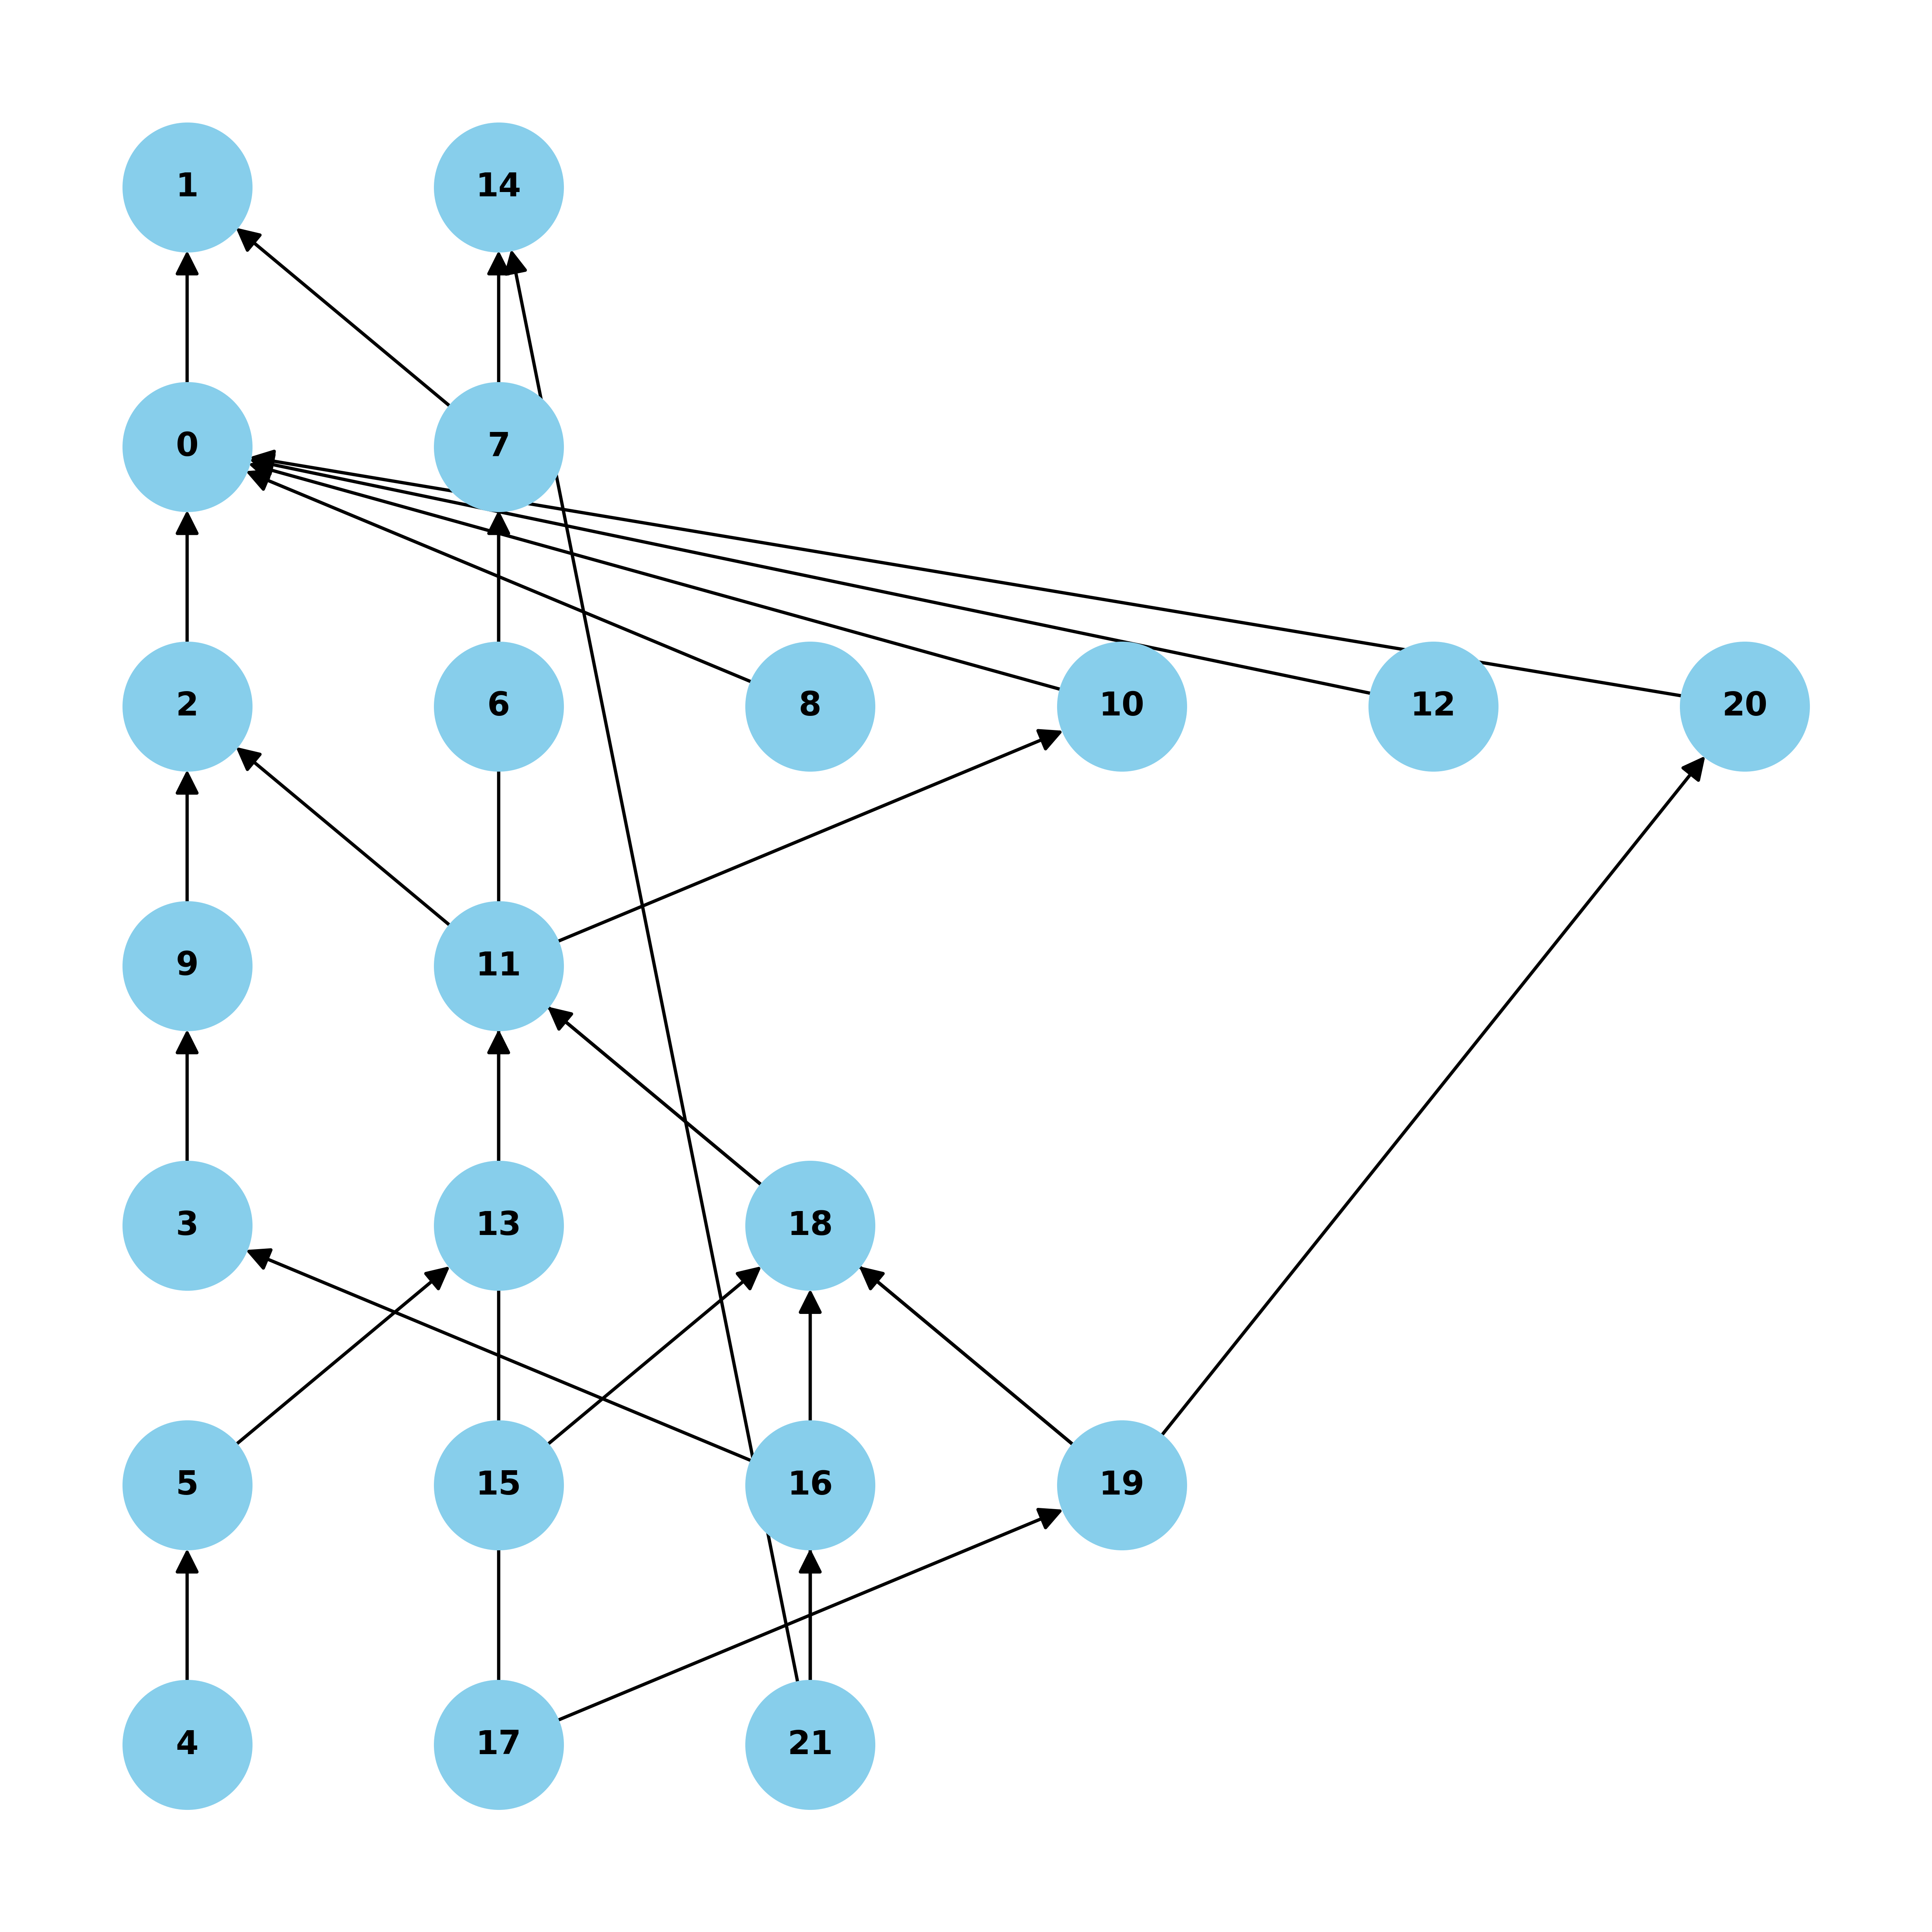

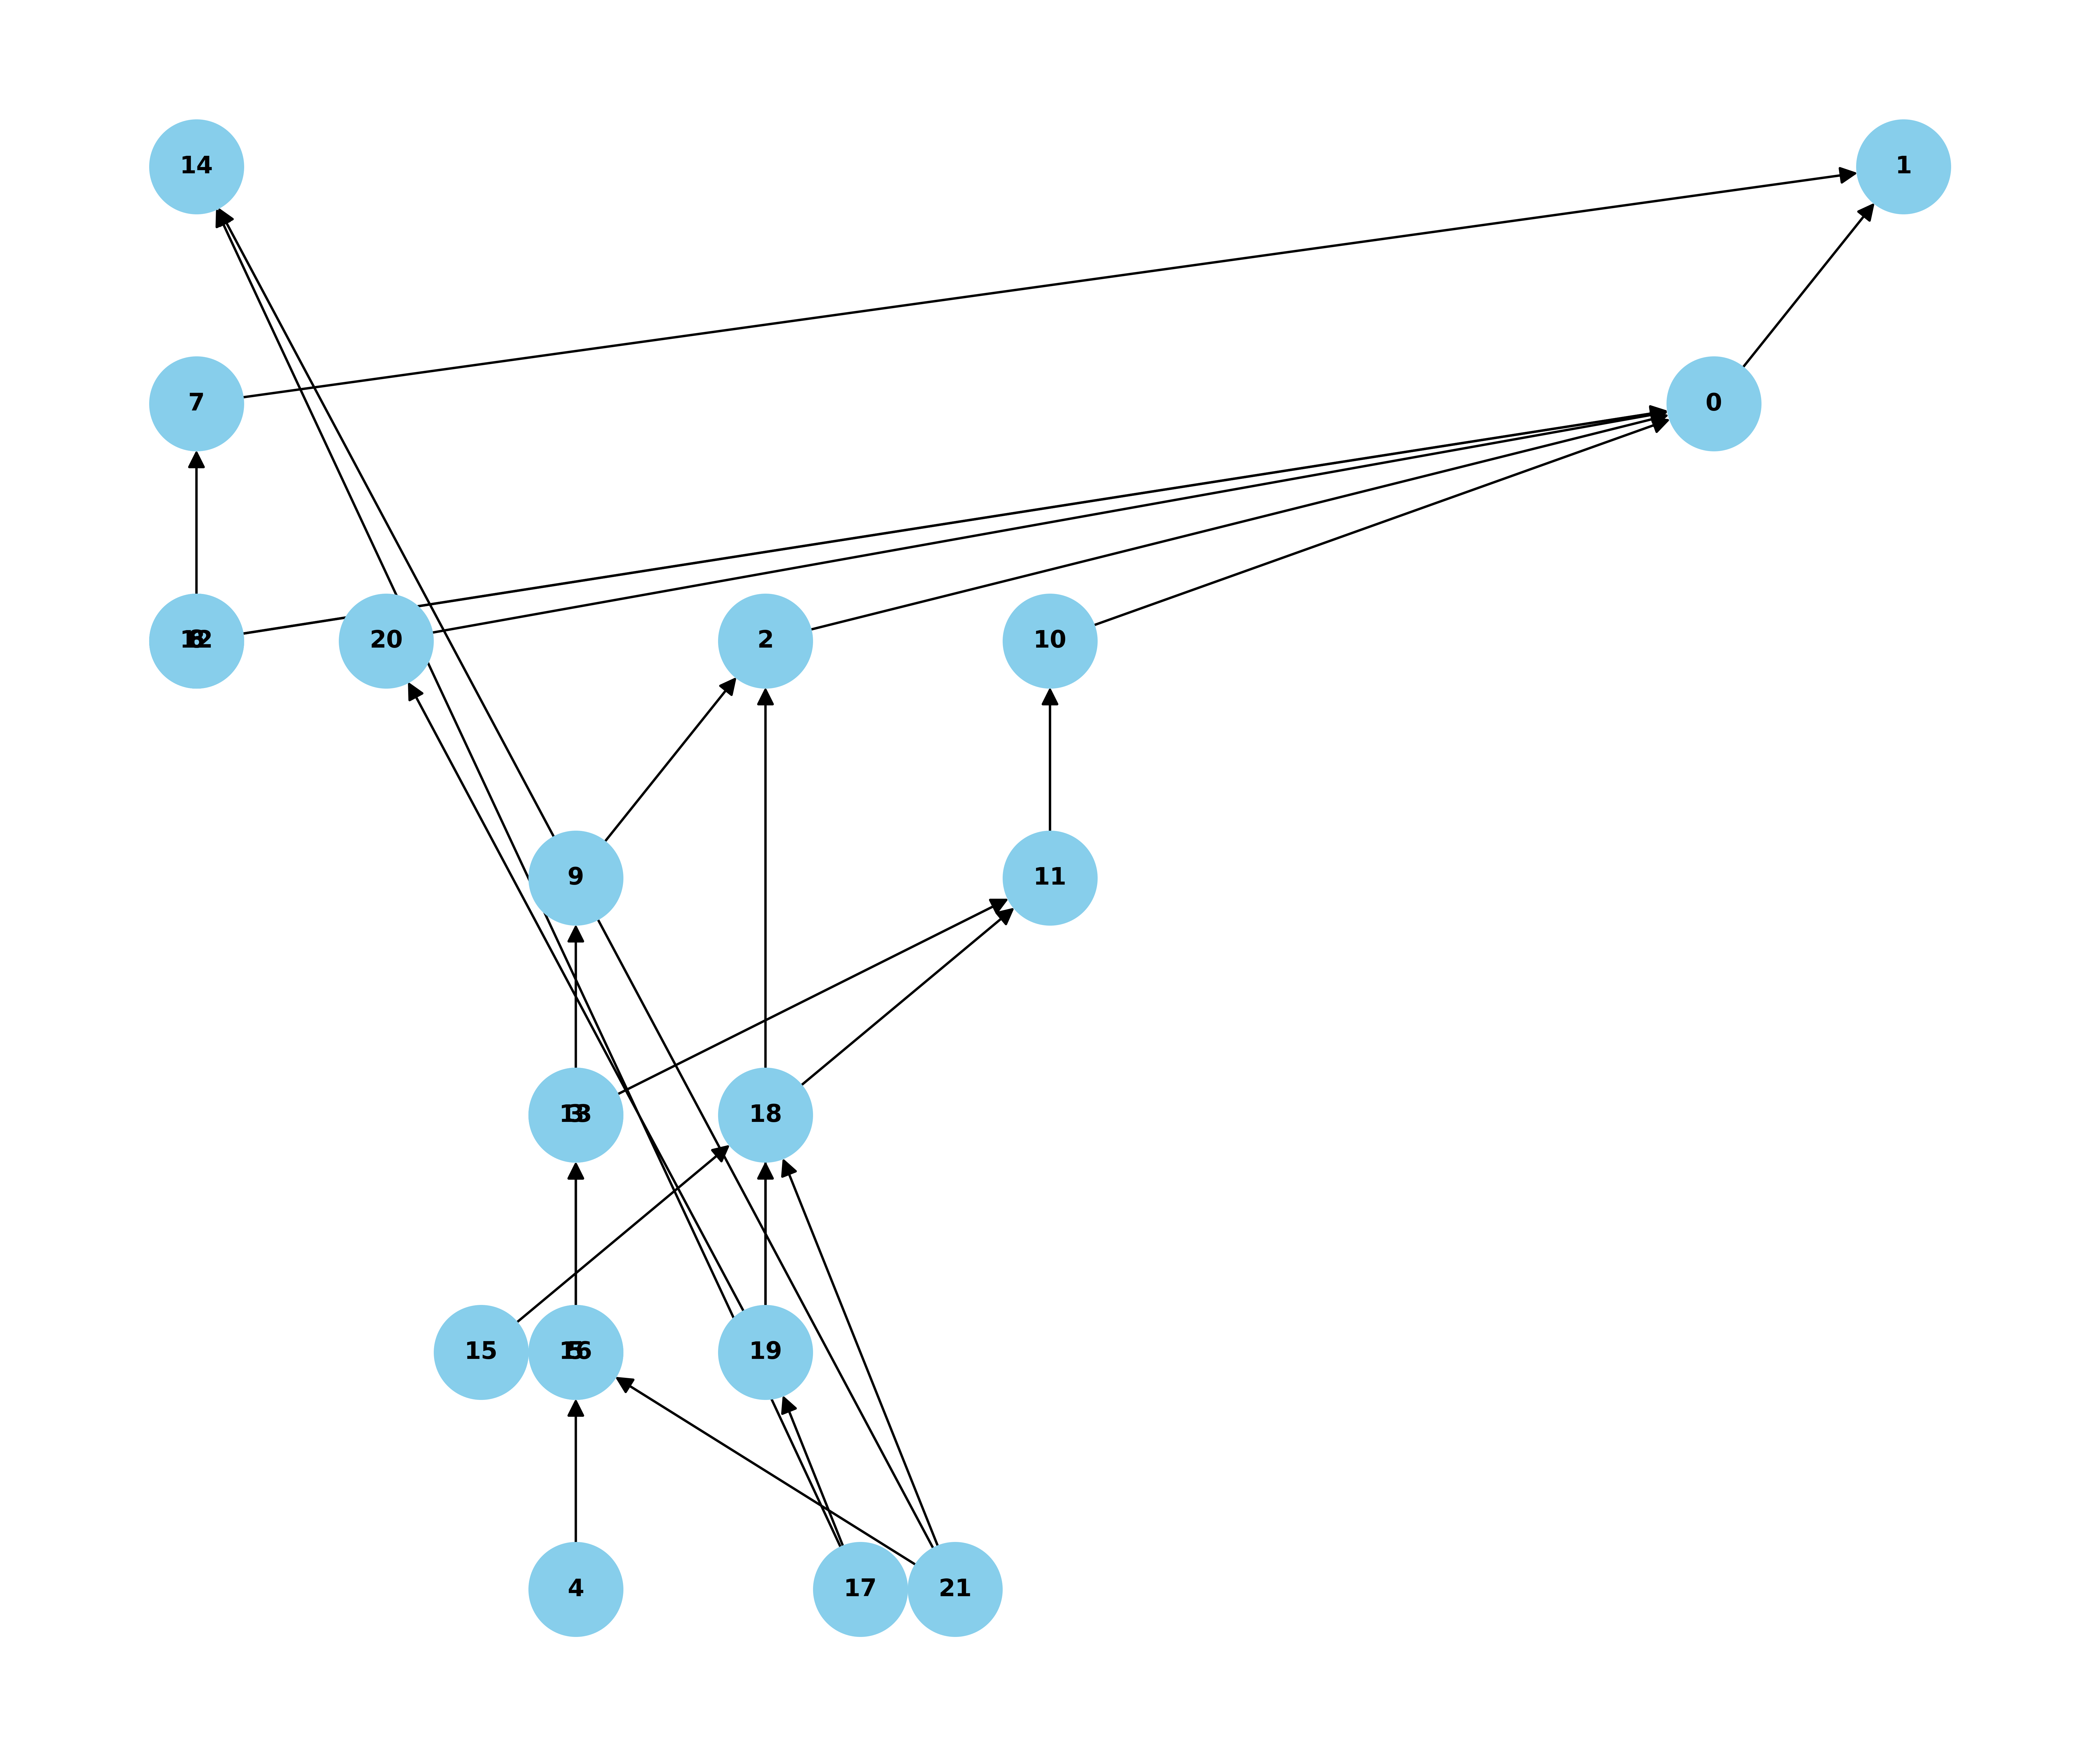

In [6]:
# ---------- ISMグラフ表示 ---------- #
# グラフを作成
G = create_graph(levels)

# ノードの配置を取得
pos = get_layer_positions(levels)

# グラフを描画して表示
plt.figure(figsize=(8, 8), dpi=600)
nx.draw(G, pos, with_labels=True, node_size=1500, node_color="skyblue", font_size=10, font_weight="bold", arrowsize=15)
plt.savefig('fig\ISM-MODEL.png', format='png')
plt.show()

# ---------- ノード位置の調整 ---------- #
# custom_posでノード番号に対応するx座標を指定する
# 自分で設定する場合
custom_pos = {3 : 1, 
              4 : 2,
              11: -1,
              16: 0}

# 関与度からcustom_posを取得する場合
custom_pos = {}
for i in range(len(matrix)):
    custom_pos[i] = d_add_r[i]

# ノードの配置を取得
pos_fix = get_layer_positions(levels, custom_pos)

# グラフを描画して表示
plt.figure(figsize=(12, 10), dpi=600)
nx.draw(G, pos_fix, with_labels=True, node_size=1500, node_color="skyblue", font_size=10, font_weight="bold", arrowsize=15)
plt.savefig('fig\ISM-MODEL_adjustment.png', format='png')
plt.show()